In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [1]:
import tensorflow as tf
import datetime
#from tensorflow.python.keras import layers
#from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

#References
#Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning


In [2]:
DATASET_PATH  = '/project/sds-capstone-aaai/met/DATA/Pytorch'
# data 
IMAGE_SIZE    = (299, 299)
#Note that the default input image size for this model is 299x299, instead of 224x224 as in the VGG16 and ResNet models.

NUM_CLASSES   = 23
#
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory

FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 25 
# epoch 
WEIGHTS_FINAL = 'model-inception_resnet_v2-final_confusion.h5'
# pretrained weights from image net - but the model will use the final weights 

In [3]:
# data pre-processing 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   validation_split=0.111,
                                   fill_mode='nearest')

In [4]:
# 
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  subset='training',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


Found 77633 images belonging to 23 classes.


In [5]:
valid_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 9682 images belonging to 23 classes.


In [6]:
# don't need to augment validation data 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 9711 images belonging to 23 classes.


In [8]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = architecture
Class #1 = birds
Class #2 = boats
Class #3 = books
Class #4 = bottles
Class #5 = bowls
Class #6 = buildings
Class #7 = dogs
Class #8 = flowers
Class #9 = hieroglyphs
Class #10 = horses
Class #11 = houses
Class #12 = landscapes
Class #13 = leaves
Class #14 = lions
Class #15 = men
Class #16 = ornament
Class #17 = sculpture
Class #18 = seals
Class #19 = soldiers
Class #20 = trees
Class #21 = vases
Class #22 = women
****************


In [9]:



# building our classifier model based on pre-trained InceptionResNetV2:
# 1. don't include the top (fully connected) layers of InceptionResNetV2
# 2. add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')



#Inception-ResNet V2 model wiith weights pre-trained on ImageNet.

net = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

# Arguments
# include_top: whether to include the fully-connected layer at the top of the network
# weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
# input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
# input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) (with 'channels_last' data format) or (3, 299, 299) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 75. E.g. (150, 150, 3) would be one valid value.
# pooling: Optional pooling mode for feature extraction when include_top is False.
# None means that the output of the model will be the 4D tensor output of the last convolutional block.
# 'avg' means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
#'max' means that global max pooling will be applied.
#classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.




x = net.output
x = Flatten()(x)
x = Dense(128, activation='relu', name="AddedDense1")(x)
x = Dropout(0.5)(x)

output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)



for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
# set optimizer = ADAM 
# set loss criterion and metrics 

net_final.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
#Top 1 Accuracy 0.803


#Top 5 Accuracy 0.953
#Now, in the case of top-1 score, you check if the top class (the one having the highest probability) is the same as the target label.

#In the case of top-5 score, you check if the target label is one of your top 5 predictions (the 5 ones with the highest probabilities).

#In both cases, the top score is computed as the times a predicted label matched the target label, divided by the number of data-points evaluated.

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


#%%capture cap --no-stderr
# beging training the model

net_final.fit(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# save trained weights
net_final.save(WEIGHTS_FINAL)







#with open('output.txt', 'w') as f:
    #f.write(cap.stdout)

In [ ]:
acc = net_final.history.history['accuracy']
val_acc = net_final.history.history['val_accuracy']
loss = net_final.history.history['loss']
val_loss = net_final.history.history['val_loss']

epochs = range(1, len(acc) + 1)

In [10]:
net_final.load_weights('model-inception_resnet_v2-final_confusion.h5')

In [12]:
import numpy
import pandas as pd
test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)

predictions = net_final.predict_generator(test_batches, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys()) 

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
report = classification_report(true_classes, predicted_classes, target_names=class_labels,output_dict=True)


df = pd.DataFrame(report).transpose()
#df.to_csv('classification_report_inceptionresnet.csv')

Instructions for updating:
Please use Model.predict, which supports generators.


In [13]:
df

,precision,recall,f1-score,support
architecture,0.517699,0.579208,0.546729,202.000000
birds,0.313149,0.367886,0.338318,492.000000
boats,0.526570,0.558974,0.542289,195.000000
books,0.580000,0.588832,0.584383,197.000000
bottles,0.745370,0.693966,0.718750,232.000000
bowls,0.789272,0.707904,0.746377,291.000000
buildings,0.531250,0.331707,0.408408,205.000000
dogs,0.446429,0.246305,0.317460,203.000000
flowers,0.509735,0.633663,0.564983,909.000000
hieroglyphs,0.903226,0.674699,0.772414,166.000000


ConversionError: Failed to convert value(s) to axis units: ['architecture', 'birds', 'boats', 'books', 'bottles', 'bowls', 'buildings', 'dogs', 'flowers', 'hieroglyphs', 'horses', 'houses', 'landscapes', 'leaves', 'lions', 'men', 'ornament', 'sculpture', 'seals', 'soldiers', 'trees', 'vases', 'women']

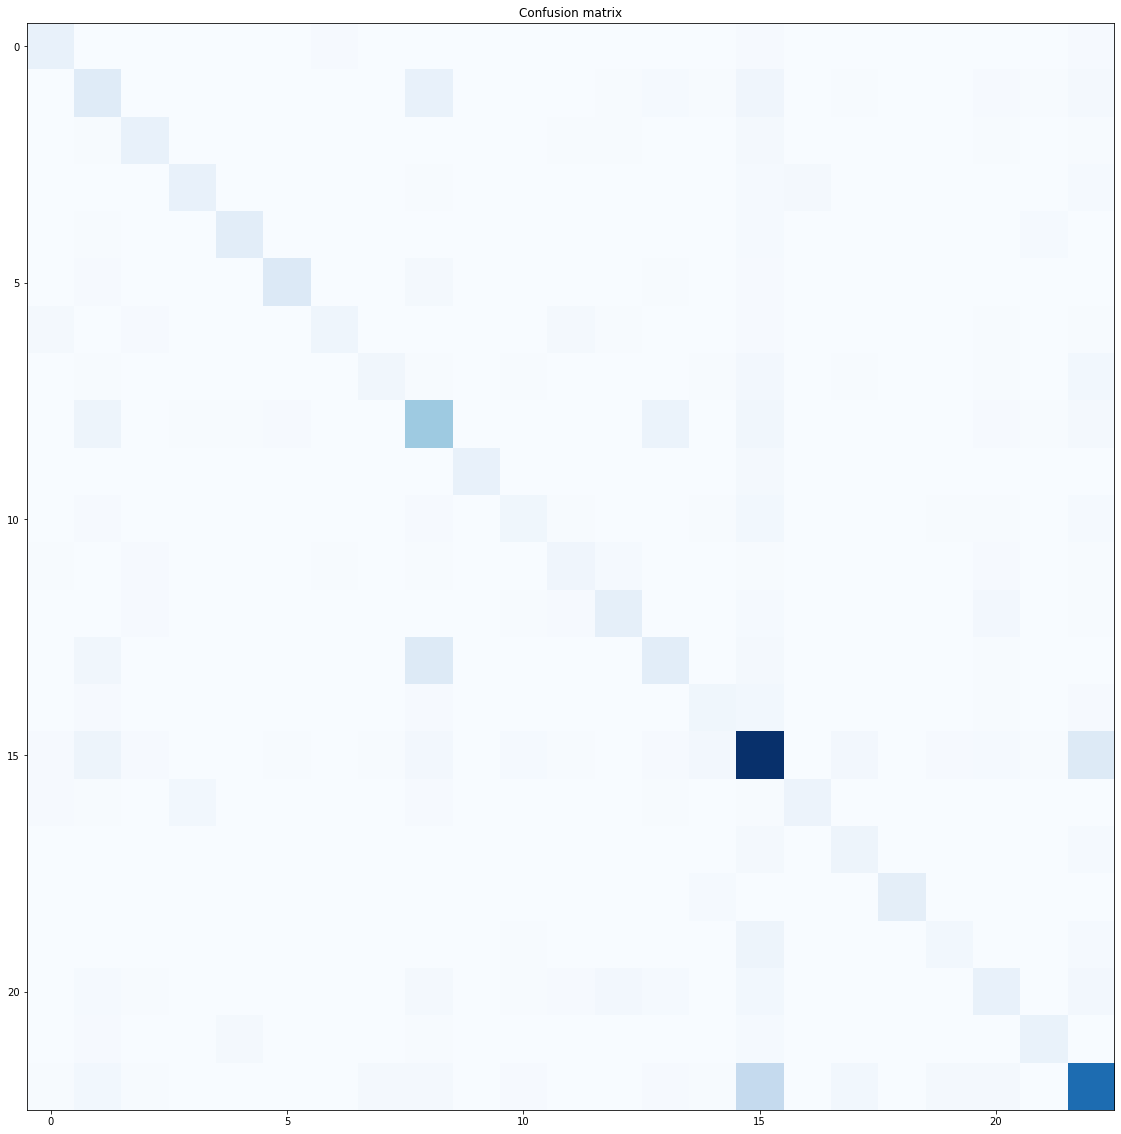

In [45]:
import matplotlib.pyplot as plt
#import seaborn as sns
labels = class_labels
cm = confusion_matrix(true_classes, predicted_classes)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
plt.imshow(cm, cmap=plt.cm.Blues)
#sns.heatmap(cm, annot=True, cmap=plt.get_cmap('Blues'))
plt.title('Confusion matrix')
plt.xticks(labels)
ax.set_yticklabels(arrays)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('confusion_inception.jpg')
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
one = pd.read_csv('resnet101_rfinal.csv')
fif = pd.read_csv('resnet50_rfinal.csv')
inc = pd.read_csv('inception_final_model.csv')
epochs = range(1, len(one) + 1)

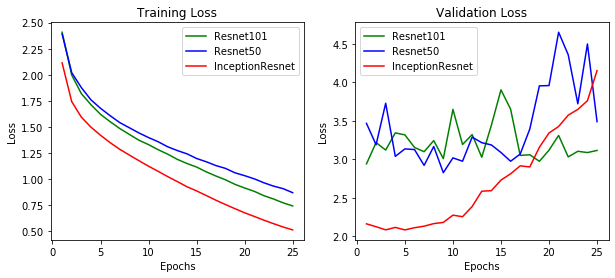

In [2]:
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(10, 4)) 
ax[0].plot(epochs, one.loss,  label = 'Resnet101',color='green')
ax[0].plot(epochs, fif.loss, label = 'Resnet50',color='blue')
ax[0].plot(epochs, inc.loss, label = 'InceptionResnet',color='red')
ax[0].title.set_text('Training Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, one.val_loss,  label = 'Resnet101',color='green')
ax[1].plot(epochs, fif.val_loss,  label = 'Resnet50',color='blue')
ax[1].plot(epochs, inc.val_loss,  label = 'InceptionResnet',color='red')

ax[1].title.set_text('Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

fig.savefig('loss.jpg')

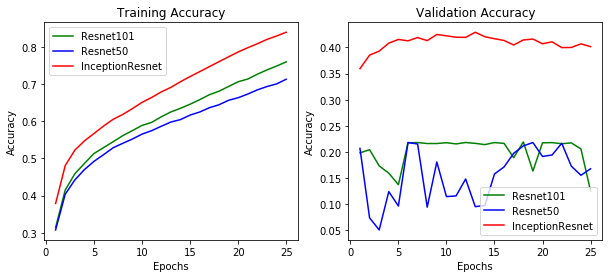

In [3]:
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(10, 4)) 
ax[0].plot(epochs, one.acc,  label = 'Resnet101',color='green')
ax[0].plot(epochs, fif.acc, label = 'Resnet50',color='blue')
ax[0].plot(epochs, inc.acc, label = 'InceptionResnet',color='red')
ax[0].title.set_text('Training Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs, one.val_acc,  label = 'Resnet101',color='green')
ax[1].plot(epochs, fif.val_acc,  label = 'Resnet50',color='blue')
ax[1].plot(epochs, inc.val_acc,  label = 'InceptionResnet',color='red')

ax[1].title.set_text('Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

fig.savefig('accuracy.jpg')

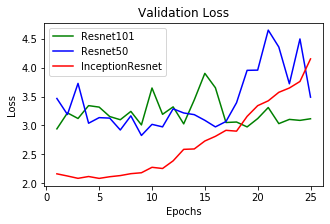

In [10]:
plt.figure(figsize=(5,3)) 

#plt.plot(epochs, one.loss,  label='Training loss/resnet101',color='green')
plt.plot(epochs, one.val_loss,  label = 'Resnet101',color='green')
#plt.plot(epochs, fif.loss,  label='Training loss/resnet50',color='blue')
plt.plot(epochs, fif.val_loss, label = 'Resnet50',color='blue')
#plt.plot(epochs, inc.loss,  label='Training loss/InceptionResnet',color='red')
plt.plot(epochs, inc.val_loss, label = 'InceptionResnet',color='red')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('floss')
plt.show()


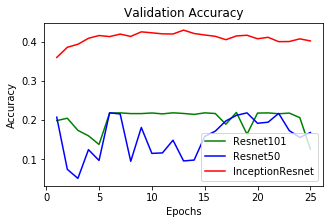

In [11]:
plt.figure(figsize=(5,3)) 

#plt.plot(epochs, one.acc,  '--',label='Training acc/resnet101',color='green')
plt.plot(epochs, one.val_acc,  label = 'Resnet101',color='green')
#plt.plot(epochs, fif.acc,  '--',label='Training acc/resnet50',color='blue')
plt.plot(epochs, fif.val_acc,  label = 'Resnet50',color='blue')
#plt.plot(epochs, inc.acc,  '--',label='Training acc/InceptionResnet',color='red')
plt.plot(epochs, inc.val_acc,  label = 'InceptionResnet',color='red')

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('facc')
plt.show()


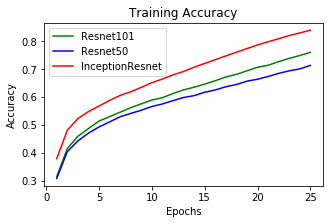

In [12]:
plt.figure(figsize=(5,3)) 

#plt.plot(epochs, one.acc,  '--',label='Training acc/resnet101',color='green')
plt.plot(epochs, one.acc,  label = 'Resnet101',color='green')
#plt.plot(epochs, fif.acc,  '--',label='Training acc/resnet50',color='blue')
plt.plot(epochs, fif.acc,  label = 'Resnet50',color='blue')
#plt.plot(epochs, inc.acc,  '--',label='Training acc/InceptionResnet',color='red')
plt.plot(epochs, inc.acc,  label = 'InceptionResnet',color='red')

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('facc')